In [52]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
np.random.seed(32)


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.utils.np_utils import to_categorical

%matplotlib inline

In [53]:
df = pd.read_csv("dataset.csv") 
df.head()

Label                                          Statement
0  Real  Seriously? Puts into perspective the challenge...
1  Real  It's being hailed a breakthrough in search of ...
2  Fake  MaverickLite I tried very hard to develop an a...
3  Fake                                  Drain The Oceans.
4  Fake                     I found MH370 on Google maps.

(array([279.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 186.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

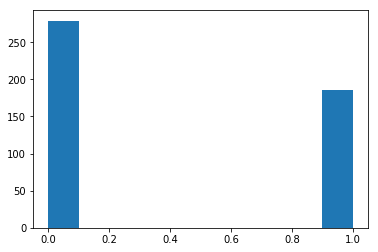

In [54]:
df['Label'] = df.Label.map({'Fake':0, 'Real':1})
plt.hist(df['Label'])

In [55]:
train_text, test_text, train_y, test_y = train_test_split(df['Statement'],df['Label'],test_size = 0.2)

In [56]:
train_text.shape

(372,)

In [57]:
MAX_NB_WORDS = 20000

# get the raw text data
texts_train = train_text.astype(str)
texts_test = test_text.astype(str)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

C:\Users\Tanvir\Anaconda3\lib\site-packages\keras_preprocessing\text.py:177: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 1270 unique tokens.


In [58]:
sequences[0]

[111, 35, 20, 127, 205, 13, 93, 206, 252, 600, 1, 253, 38, 94, 601]

In [59]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 1270)

In [60]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [61]:
" ".join([index_to_word[i] for i in sequences[0]])

'these two bto 51 700 and 17 120 mcs provided the mekar ping rings intersection'

In [62]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 14.8
max length: 55


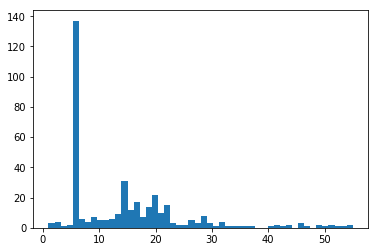

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=50);

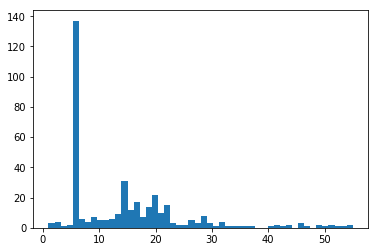

In [64]:
plt.hist([l for l in seq_lens if l < 200], bins=50);

In [65]:
MAX_SEQUENCE_LENGTH = 150

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (372, 150)
Shape of data test tensor: (93, 150)


In [66]:
y_train = train_y
y_test = test_y

y_train = to_categorical(np.asarray(y_train))
y_test = to_categorical(np.asarray(y_test))
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (372, 2)


In [67]:
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

EMBEDDING_DIM = 50
N_CLASSES = 2

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [68]:
model.fit(x_train, y_train, validation_split=0.1,
          nb_epoch=10, batch_size=128)

C:\Users\Tanvir\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 334 samples, validate on 38 samples
Epoch 1/10
334/334 [==============================] - 37s 111ms/step - loss: 0.6886 - acc: 0.6108 - val_loss: 0.6863 - val_acc: 0.5789
Epoch 2/10
334/334 [==============================] - 0s 948us/step - loss: 0.6839 - acc: 0.6108 - val_loss: 0.6827 - val_acc: 0.5789
Epoch 3/10
334/334 [==============================] - 0s 1ms/step - loss: 0.6786 - acc: 0.6108 - val_loss: 0.6798 - val_acc: 0.5789
Epoch 4/10
334/334 [==============================] - 0s 889us/step - loss: 0.6755 - acc: 0.6108 - val_loss: 0.6771 - val_acc: 0.5789
Epoch 5/10
334/334 [==============================] - 0s 901us/step - loss: 0.6723 - acc: 0.6108 - val_loss: 0.6748 - val_acc: 0.5789
Epoch 6/10
334/334 [==============================] - 0s 842us/step - loss: 0.6691 - acc: 0.6108 - val_loss: 0.6728 - val_acc: 0.5789
Epoch 7/10
334/334 [==============================] - 0s 896us/step - loss: 0.6664 - acc: 0.6108 - val_loss: 0.6711 - val_acc: 0.5789
Epoch 8/10
334/334

In [69]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test))

test auc: 0.7537735849056604


In [70]:
print(y_test.shape)

(93, 2)


In [71]:
loss, accuracy = model.evaluate(x_train,y_train , verbose=False)
print("Training Accuracy: {:.2f}".format(accuracy))
loss, accuracy = model.evaluate(x_test,y_test, verbose=False)
print("Testing Accuracy:  {:.2f}".format(accuracy))

Training Accuracy: 0.61
Testing Accuracy:  0.57


In [72]:
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

from keras.layers import Bidirectional,GRU

#x = LSTM(256, dropout=0.2, return_sequences=True,recurrent_dropout=0.2)(embedded_sequences)
#x = LSTM(128, dropout=0.2, return_sequences=True,recurrent_dropout=0.2)(x)
#x = LSTM(128, dropout=0.2, return_sequences=True,recurrent_dropout=0.2)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)#(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(GRU(64, return_sequences=False))(x)


predictions = Dense(2, activation='softmax')(x)


model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['acc'])


In [73]:
model.fit(x_train, y_train, validation_split=0.2,
          nb_epoch=10, batch_size=64)

C:\Users\Tanvir\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 297 samples, validate on 75 samples
Epoch 1/10
297/297 [==============================] - 132s 446ms/step - loss: 0.6989 - acc: 0.6465 - val_loss: 0.4315 - val_acc: 0.8267
Epoch 2/10
297/297 [==============================] - 60s 202ms/step - loss: 0.4146 - acc: 0.8316 - val_loss: 0.3708 - val_acc: 0.8267
Epoch 3/10
297/297 [==============================] - 60s 202ms/step - loss: 0.3168 - acc: 0.8855 - val_loss: 0.3720 - val_acc: 0.8267
Epoch 4/10
297/297 [==============================] - 62s 210ms/step - loss: 0.2676 - acc: 0.9293 - val_loss: 0.3951 - val_acc: 0.8267
Epoch 5/10
297/297 [==============================] - 60s 200ms/step - loss: 0.2352 - acc: 0.9327 - val_loss: 0.6048 - val_acc: 0.7333
Epoch 6/10
297/297 [==============================] - 61s 204ms/step - loss: 0.2565 - acc: 0.9091 - val_loss: 0.3859 - val_acc: 0.8000
Epoch 7/10
297/297 [==============================] - 59s 199ms/step - loss: 0.2403 - acc: 0.9192 - val_loss: 0.4182 - val_acc: 0.8000
Epoch 8/1

In [74]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test))

test auc: 0.8070754716981132


In [75]:
loss, accuracy = model.evaluate(x_train,y_train , verbose=False)
print("Training Accuracy: {:.2f}".format(accuracy))
loss, accuracy = model.evaluate(x_test,y_test, verbose=False)
print("Testing Accuracy:  {:.2f}".format(accuracy))

Training Accuracy: 0.92
Testing Accuracy:  0.72


In [76]:
import keras
from keras.layers import Bidirectional
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# 1D convolution with 64 output channels
x = Conv1D(64, 5)(embedded_sequences)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(5)(x)
x = Dropout(0.5)(x)
x = Conv1D(64, 5)(x)
x = MaxPooling1D(5)(x)
# LSTM layer with a hidden size of 64
x = Dropout(0.5)(x)
x = LSTM(128,return_sequences=True)(x)
x = LSTM(64,return_sequences=True)(x)
x = LSTM(32, return_sequences=True)(x)

x = Bidirectional(LSTM(LSTM_OUT, return_sequences=False, dropout=0.25, recurrent_dropout=0.1))(x)
predictions = Dense(2, activation='sigmoid')(x)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['acc'])

NameError: name 'LSTM_OUT' is not defined

In [ ]:
model.fit(x_train, y_train, validation_split=0.2,
          nb_epoch=15, batch_size=128)

In [ ]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test))

In [ ]:
loss, accuracy = model.evaluate(x_train,y_train , verbose=False)
print("Training Accuracy: {:.2f}".format(accuracy))
loss, accuracy = model.evaluate(x_test,y_test, verbose=False)
print("Testing Accuracy:  {:.2f}".format(accuracy))

In [ ]:
def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_train, K.round(y_test)), axis=-1)

In [ ]:
from keras import backend as K
get_emb_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].input])
embedding_output = get_emb_layer_output([x_test[:3000]])[0]

In [ ]:
emb_shape = embedding_output.shape
to_plot_embedding = embedding_output.reshape(emb_shape[0],emb_shape[1]*emb_shape[2])
y = y_test[:3000]

In [ ]:
sentence_emb_tsne = TSNE(perplexity=30).fit_transform(to_plot_embedding)

In [ ]:
print(sentence_emb_tsne.shape)
print(y.shape)

In [ ]:
plt.figure()
plt.scatter(sentence_emb_tsne[np.where(y == 0), 0],
                   sentence_emb_tsne[np.where(y == 0), 1],
                   marker='x', color='g',
                   linewidth='1', alpha=0.8, label='Happy')
plt.scatter(sentence_emb_tsne[np.where(y == 1), 0],
                   sentence_emb_tsne[np.where(y == 1), 1],
                   marker='v', color='r',
                   linewidth='1', alpha=0.8, label='Unhappy')

plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('T-SNE')
plt.legend(loc='best')
plt.savefig('1.png')
plt.show()  